In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split

def load_videos_from_directory(directory, label, num_frames=36, height=256, width=256):
    videos = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".mp4"):
            video_path = os.path.join(directory, filename)
            cap = cv2.VideoCapture(video_path)
            frames = []
            while len(frames) < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (width, height))
                frames.append(frame)
            cap.release()
            if len(frames) == num_frames:
                videos.append(np.array(frames))
                labels.append(label)
    
    return videos, labels

# Verileri yükle
rotation_videos, rotation_labels = load_videos_from_directory('/home/muhlabws4/Videolar/d3c4_azaltilmis', 1)
random_videos, random_labels = load_videos_from_directory('/home/muhlabws4/Videolar/random_d3c4', 0)

# Veriyi birleştirin
X = np.array(rotation_videos + random_videos)
y = np.array(rotation_labels + random_labels)

# Eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
print("X Shape:", X.shape)
print("y Shape:", y.shape)
print("Sample video shape:", X[0].shape if len(X) > 0 else "No data")
print("Sample label:", y[0] if len(y) > 0 else "No data")


X Shape: (348, 36, 256, 256, 3)
y Shape: (348,)
Sample video shape: (36, 256, 256, 3)
Sample label: 1


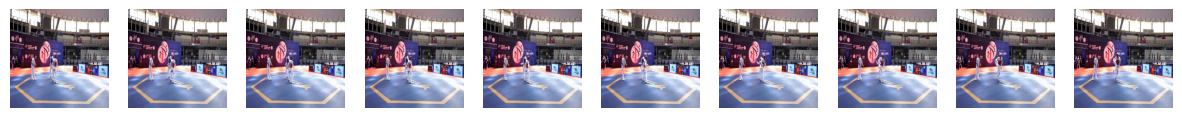

In [3]:
import matplotlib.pyplot as plt

def display_video_frames(video_frames):
    num_frames = len(video_frames)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i, frame in enumerate(video_frames):
        axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.show()

# İlk videoyu al ve ilk birkaç karesini görüntüle
if len(X) > 0:
    display_video_frames(X[0][:10])  # İlk 10 frame'i göster
else:
    print("No video data to display")


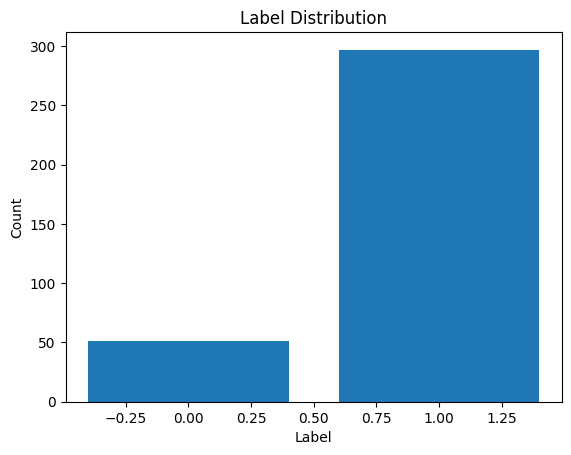

In [4]:
import matplotlib.pyplot as plt

unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

def create_model(input_shape):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Modeli oluşturun
input_shape = (36, 256, 256, 3)  # 36 frame, 256x256 boyut, 3 renk kanalı
model = create_model(input_shape)

# Modelin özetini yazdırın
model.summary()


2024-09-02 15:30:55.051149: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 15:30:55.084321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 15:30:55.093318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 15:30:55.095921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 15:30:55.102717: I tensorflow/core/platform/cpu_feature_guar

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 34, 254, 254,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 17, 127, 127,   │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 125, 125,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 62, 62, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 60, 60, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    29,491,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,770,753 (113.57 MB)

 Trainable params: 29,770,753 (113.57 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=8, 
                    validation_split=0.1,
                    verbose=1)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8269 - loss: 225.3970 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9826 - loss: 0.0596 - val_accuracy: 1.0000 - val_loss: 4.7923e-37
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 1.0000 - loss: 3.8547e-19 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 1.0000 - loss: 4.8247e-30 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 1.0000 - loss: 3.4018e-25 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 1.0000 - loss: 2.4573e-26 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 1.0000 - loss: 3.8833e-30 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 1.0000

In [7]:
# Test setini değerlendirin
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Tahminler yapın
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Sonuçları yazdırın
print("Predicted Labels:", predicted_labels.flatten())
print("True Labels:", y_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Predicted Labels: [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
True Labels: [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


In [9]:
print(y_test)

[1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


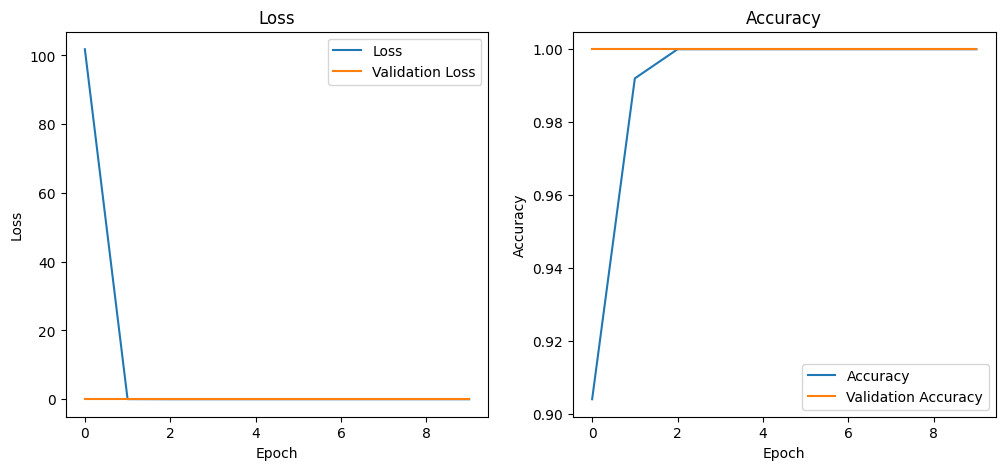

In [8]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını ve doğruluğunu çizme
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [10]:
model.save('video_classification_model.h5')
